In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.optimizers as tfko
from tfdiffeq import odeint

Epoch: 0  loss: 19531.988543749154
Epoch: 1  loss: 17653.760065417795
Epoch: 2  loss: 16135.011262496844
Epoch: 3  loss: 14905.966253268998
Epoch: 4  loss: 13909.256971878987
Epoch: 5  loss: 13098.383018495488
Epoch: 6  loss: 12436.04193741404
Epoch: 7  loss: 11892.517011732225
Epoch: 8  loss: 11444.230890043436
Epoch: 9  loss: 11072.509593893988
Epoch: 10  loss: 10762.561491898789
Epoch: 11  loss: 10502.653002696105
Epoch: 12  loss: 10283.453064184194
Epoch: 13  loss: 10097.517001112818
Epoch: 14  loss: 9938.882958293587
Epoch: 15  loss: 9802.756614998205
Epoch: 16  loss: 9685.265842616607
Epoch: 17  loss: 9583.269094220963
Epoch: 18  loss: 9494.205917046274
Epoch: 19  loss: 9415.979667236406
Epoch: 20  loss: 9346.865706345434
Epoch: 21  loss: 9285.438667607574
Epoch: 22  loss: 9230.515144091642
Epoch: 23  loss: 9181.108083092633
Epoch: 24  loss: 9136.390417348472
Epoch: 25  loss: 9095.665933086575
Epoch: 26  loss: 9058.345840087379
Epoch: 27  loss: 9023.929859727443
Epoch: 28  loss: 

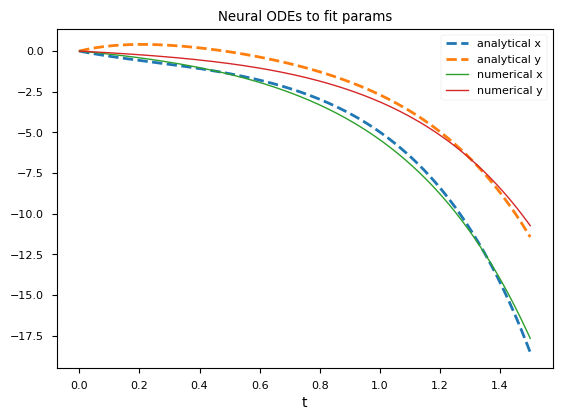

In [2]:
def parametric_ode_system(t, u, args):
    a1, b1, c1, d1, a2, b2, c2, d2 = \
        args[0], args[1], args[2], args[3], \
        args[4], args[5], args[6], args[7]
    x, y = u[0], u[1]
    dx_dt = a1*x + b1*y + c1*tf.math.exp(-d1*t)
    dy_dt = a2*x + b2*y + c2*tf.math.exp(-d2*t)
    return tf.stack([dx_dt, dy_dt])

true_params = [1.11, 2.43, -3.66, 1.37, 2.89, -1.97, 4.58, 2.86]

an_sol_x = lambda t : \
  -1.38778e-17 * np.exp(-8.99002 * t) - \
  2.77556e-17 * np.exp(-7.50002 * t) + \
  3.28757 * np.exp(-3.49501 * t) - \
  3.18949 * np.exp(-2.86 * t) + \
  0.258028 * np.exp(-1.37 * t) - \
  0.356108 * np.exp(2.63501 * t) +  \
  4.44089e-16 * np.exp(3.27002 * t) + \
  1.11022e-16 * np.exp(4.76002 * t)

an_sol_y = lambda t : \
  -6.23016 * np.exp(-3.49501 * t) + \
  5.21081 * np.exp(-2.86 * t) + \
  1.24284 * np.exp(-1.37 * t) - \
  0.223485 * np.exp(2.63501 * t) + \
  2.77556e-17 * np.exp(4.76002 * t)

t_begin=0.
t_end=1.5
t_nsamples=150
t_space = np.linspace(t_begin, t_end, t_nsamples)

dataset_outs = [tf.expand_dims(an_sol_x(t_space), axis=1), \
                tf.expand_dims(an_sol_y(t_space), axis=1)]

t_space_tensor = tf.constant(t_space)
x_init = tf.constant([0.], dtype=t_space_tensor.dtype)
y_init = tf.constant([0.], dtype=t_space_tensor.dtype)
u_init = tf.convert_to_tensor([x_init, y_init], dtype=t_space_tensor.dtype)
args = [tf.Variable(initial_value=1., name='p' + str(i+1), trainable=True,
          dtype=t_space_tensor.dtype) for i in range(0, 8)]

learning_rate = 0.05
epochs = 200
optimizer = tfko.Adam(learning_rate=learning_rate)

def net():
  return odeint(lambda ts, u0: parametric_ode_system(ts, u0, args),
                  u_init, t_space_tensor)

def loss_func(num_sol):
  return tf.reduce_sum(tf.square(dataset_outs[0] - num_sol[:, 0])) + \
         tf.reduce_sum(tf.square(dataset_outs[1] - num_sol[:, 1]))

for epoch in range(epochs):
  with tf.GradientTape() as tape:
    num_sol = net()
    loss_value = loss_func(num_sol)
  print("Epoch:", epoch, " loss:", loss_value.numpy())
  grads = tape.gradient(loss_value, args)
  optimizer.apply_gradients(zip(grads, args))

print("Learned parameters:", [args[i].numpy() for i in range(0, 4)])
num_sol = net()
x_num_sol = num_sol[:, 0].numpy()
y_num_sol = num_sol[:, 1].numpy()

x_an_sol = an_sol_x(t_space)
y_an_sol = an_sol_y(t_space)

plt.figure()
plt.plot(t_space, x_an_sol,'--', linewidth=2, label='analytical x')
plt.plot(t_space, y_an_sol,'--', linewidth=2, label='analytical y')
plt.plot(t_space, x_num_sol, linewidth=1, label='numerical x')
plt.plot(t_space, y_num_sol, linewidth=1, label='numerical y')
plt.title('Neural ODEs to fit params')
plt.xlabel('t')
plt.legend()
plt.show()